In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from itertools import chain
from skimage.io import imread, imshow

##Import any other packages you may need here

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
588,00003043_000.png,No Finding,0,3043,041Y,M,PA,2500,2048,0.171000,0.171000
2892,00014264_012.png,No Finding,12,14264,058Y,M,AP,2500,2048,0.168000,0.168000
5251,00028182_000.png,No Finding,0,28182,068Y,M,PA,2021,2015,0.194311,0.194311


In [3]:
## EDA
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(5) 

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
66571,00016468_000.png,No Finding,0,16468,52,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52342,00013214_008.png,No Finding,8,13214,25,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
39171,00010270_008.png,Atelectasis,8,10270,16,M,PA,2846,2865,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98651,00026082_002.png,Infiltration,2,26082,53,F,PA,2544,3056,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
102931,00027441_004.png,Atelectasis|Edema|Effusion|Infiltration|Pleura...,4,27441,11,F,AP,2136,2536,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


[Text(0, 0.5, 'Number of Images with Label')]

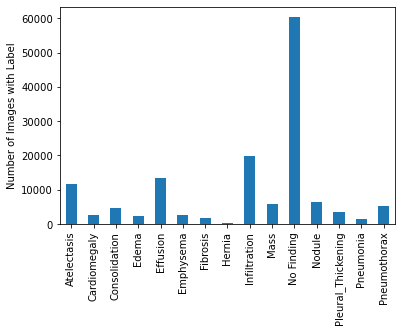

In [4]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

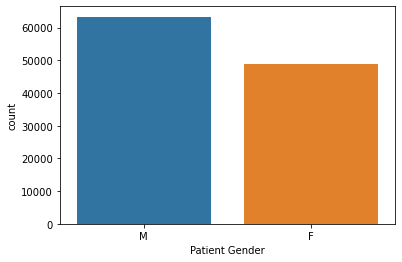

In [5]:
sns.countplot(data=all_xray_df, x='Patient Gender');

### Here I found that one patient's age was 414, which was likely wrong. So I will need to exclude this sample in my training later.

In [6]:
all_xray_df['Patient Age'].describe()

count    112120.000000
mean         46.901463
std          16.839923
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max         414.000000
Name: Patient Age, dtype: float64

### I set the maximum age limit to 120 and found that the oldest patient in our data set is 95 years old, and the youngest is one year old.

In [7]:
all_xray_df[all_xray_df['Patient Age'] < 120].describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,0.0,112104.000000,112104.000000,...,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000,112104.000000
mean,8.574172,14345.720724,46.872574,2646.035253,2486.393153,0.155651,0.155651,NaN,0.103101,0.024763,...,0.022443,0.015040,0.002025,0.177433,0.051550,0.538366,0.056474,0.030186,0.012756,0.047286
std,15.406734,8403.980520,16.598152,341.243771,401.270806,0.016174,0.016174,NaN,0.304092,0.155402,...,0.148121,0.121711,0.044954,0.382037,0.221118,0.498528,0.230836,0.171100,0.112220,0.212252
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7308.000000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,95.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 0, 'Patient Age')

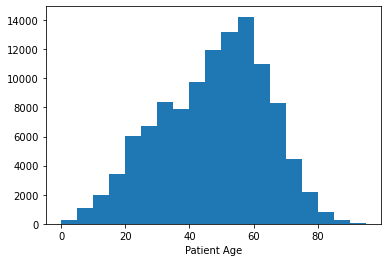

In [8]:
all_xray_df = all_xray_df[all_xray_df['Patient Age'] < 120]
bins = np.arange(0, all_xray_df['Patient Age'].max() + 5, 5)
plt.hist(all_xray_df['Patient Age'], bins=bins)
plt.xlabel('Patient Age')

### The xray images have two different view positions: PA and AP

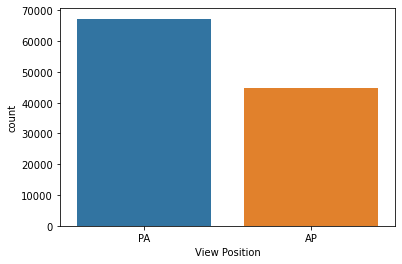

In [9]:
sns.countplot(data=all_xray_df, x='View Position');

### This data has 1430 Pneumonia cases and 110689 non-Pneumonia cases

In [10]:
all_xray_df[all_xray_df.Pneumonia == 1]['Pneumonia'].value_counts()

1.0    1430
Name: Pneumonia, dtype: int64

In [11]:
all_xray_df[all_xray_df.Pneumonia == 0]['Pneumonia'].value_counts()

0.0    110674
Name: Pneumonia, dtype: int64

### There are both male (837) and female (593) pneumonia cases in this dataset

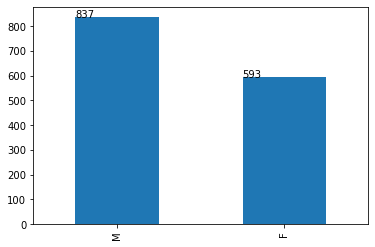

In [12]:
ax = all_xray_df[all_xray_df.Pneumonia == 1]['Patient Gender'].value_counts().plot(kind='bar');

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()))

#### The figure below shows the distribution of other diseases that are comorbid with pneumonia. Infiltration, Edema, Atelectasis occur more commonly with pneumonia than other diseases.

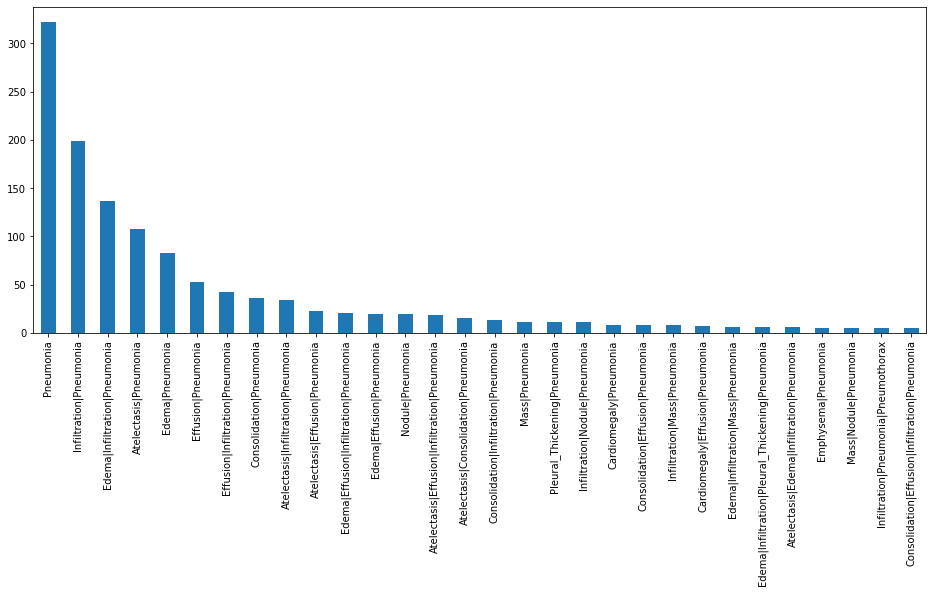

In [13]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar');

In [14]:
pne = all_xray_df[all_xray_df.Pneumonia == 1]

### Frequency distribution of disease labels that co-occur with pneumonia

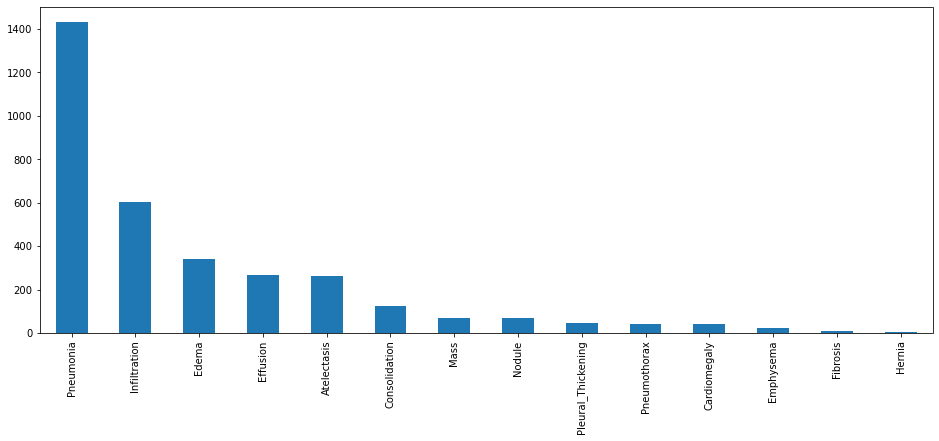

In [15]:
diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
ax = pne[diseases].sum().sort_values(ascending=False)
plt.figure(figsize=(16,6))
ax.plot(kind='bar');

Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.
Note: use full NIH data to perform the first a few EDA items and use sample_labels.csv for the pixel-level assassements.

In [16]:
paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)
sample_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path_img
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000032_001.png


### Samples of Pneumonia and Non-Pneumonia x-rays intensity distributions.
For most of the pneumonia samples, the peaks lie between 100 to 150. Some images have very high peaks around 0. That is because those images contains larger part of background. Some images have multiple spikes due to implants. In non-pneumonia examples images without implants, there tend to be a peak around 50. 
Some of the images do not have continuous distributions, or have sharp spikes around 0. Some possible causes are improper positioning of patients or improper methods while taking the images.

In [17]:
hist = sample_df[sample_df["Finding Labels"].str.match('Pneumonia')]
data = []
for p in range(14):
    data.append(("pneumonia", hist.iloc[p]["path_img"]))

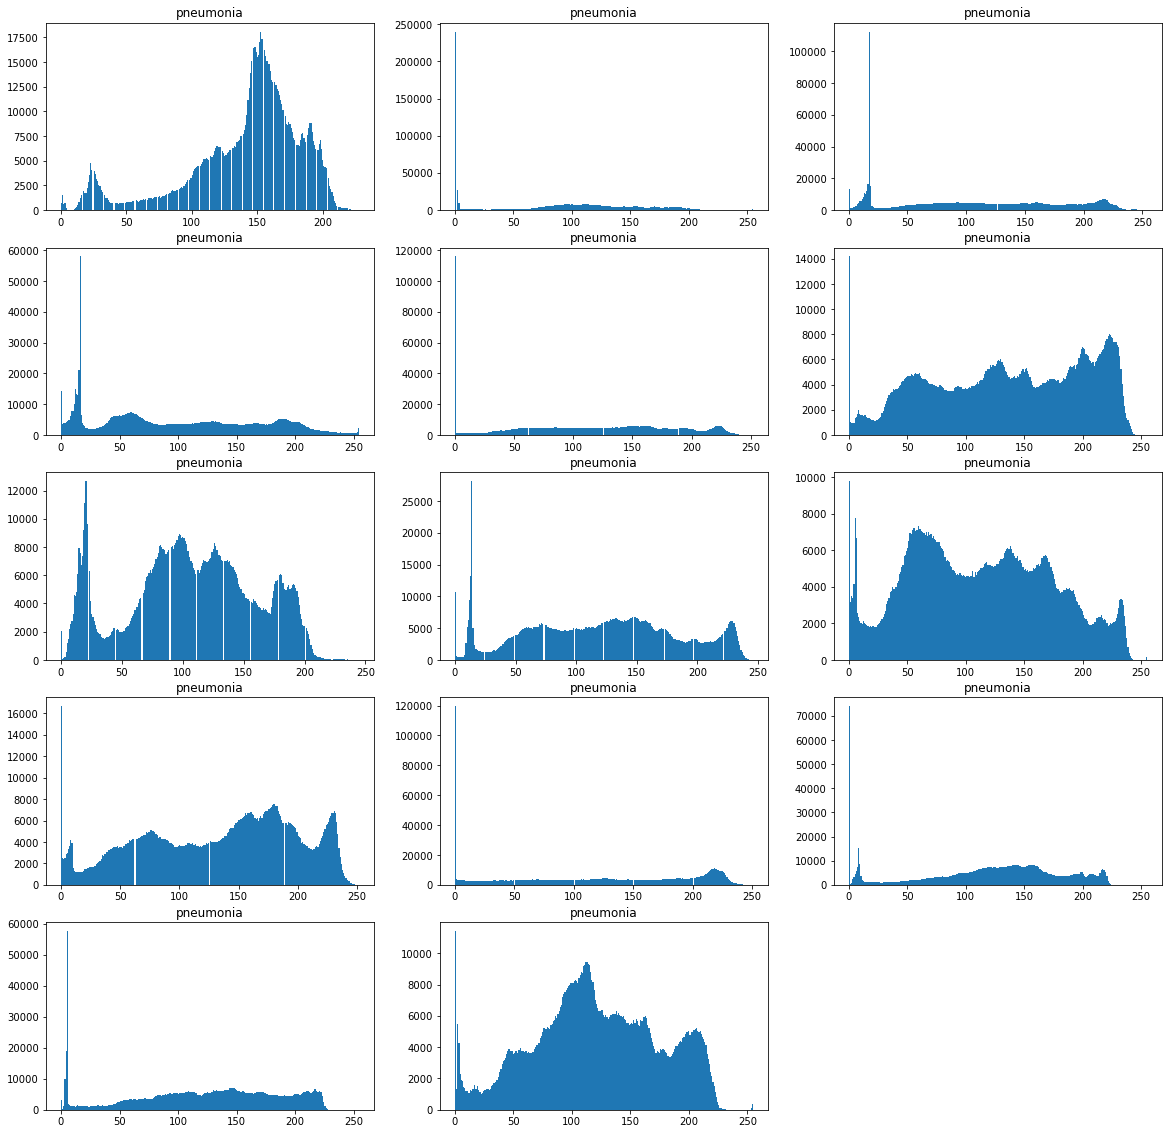

In [24]:
plt.figure(figsize=(20, 20))
columns = 3
for i in range(len(data)):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('pneumonia')
    var = plt.imread(data[i][1])
    plt.hist(var.ravel()*255, bins=256)

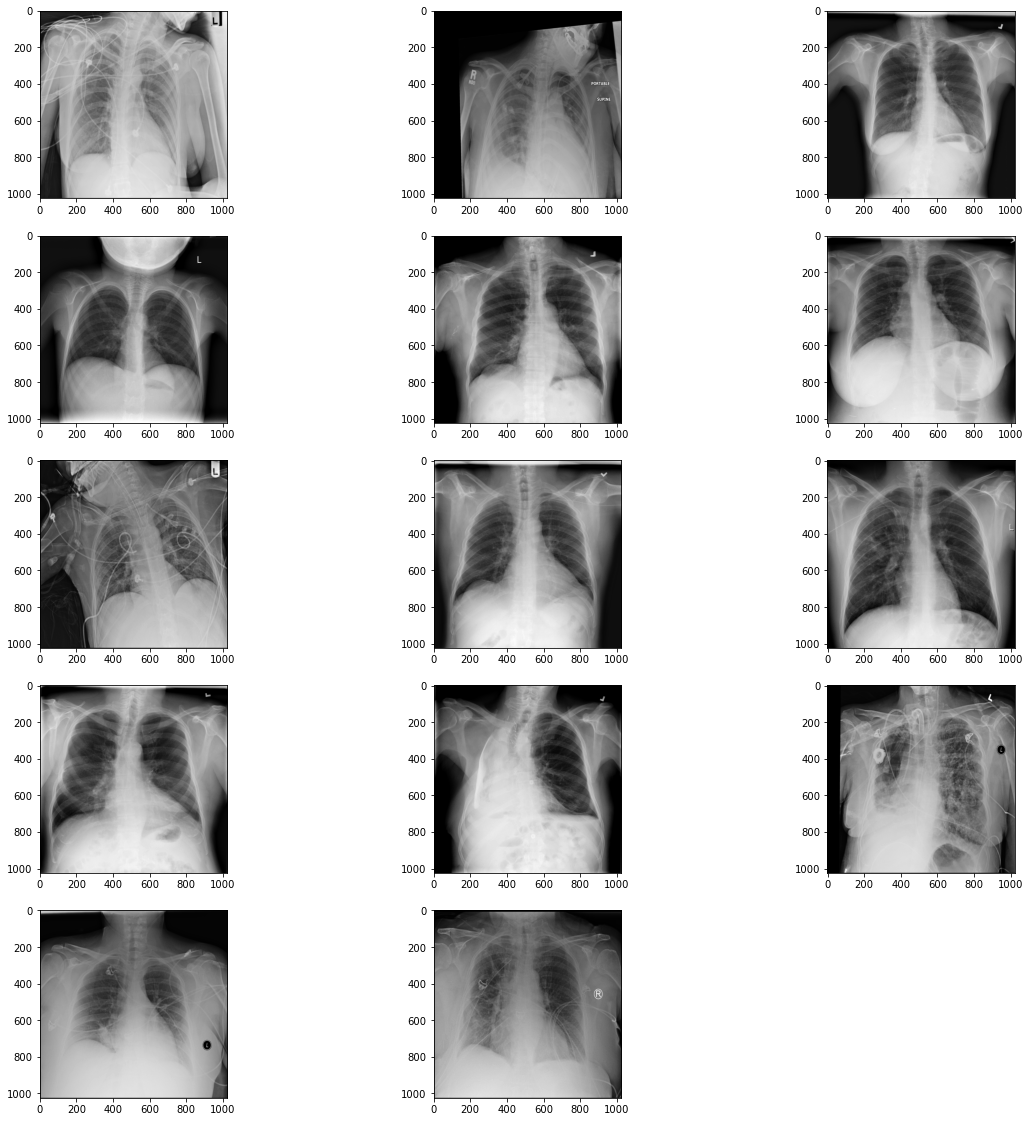

In [19]:
images = []
for i in range(len(data)):
    images.append(data[i][1])

plt.figure(figsize=(20, 20))
for i, img_path in enumerate(images):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(5, 3, i + 1)
    sp.axis()

    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')

plt.show()

In [20]:
no_finding = sample_df[sample_df["Finding Labels"].str.match('No Finding')]
no_finding_df = []
for p in range(14):
    no_finding_df.append(("no pneumonia", no_finding.iloc[p]["path_img"]))

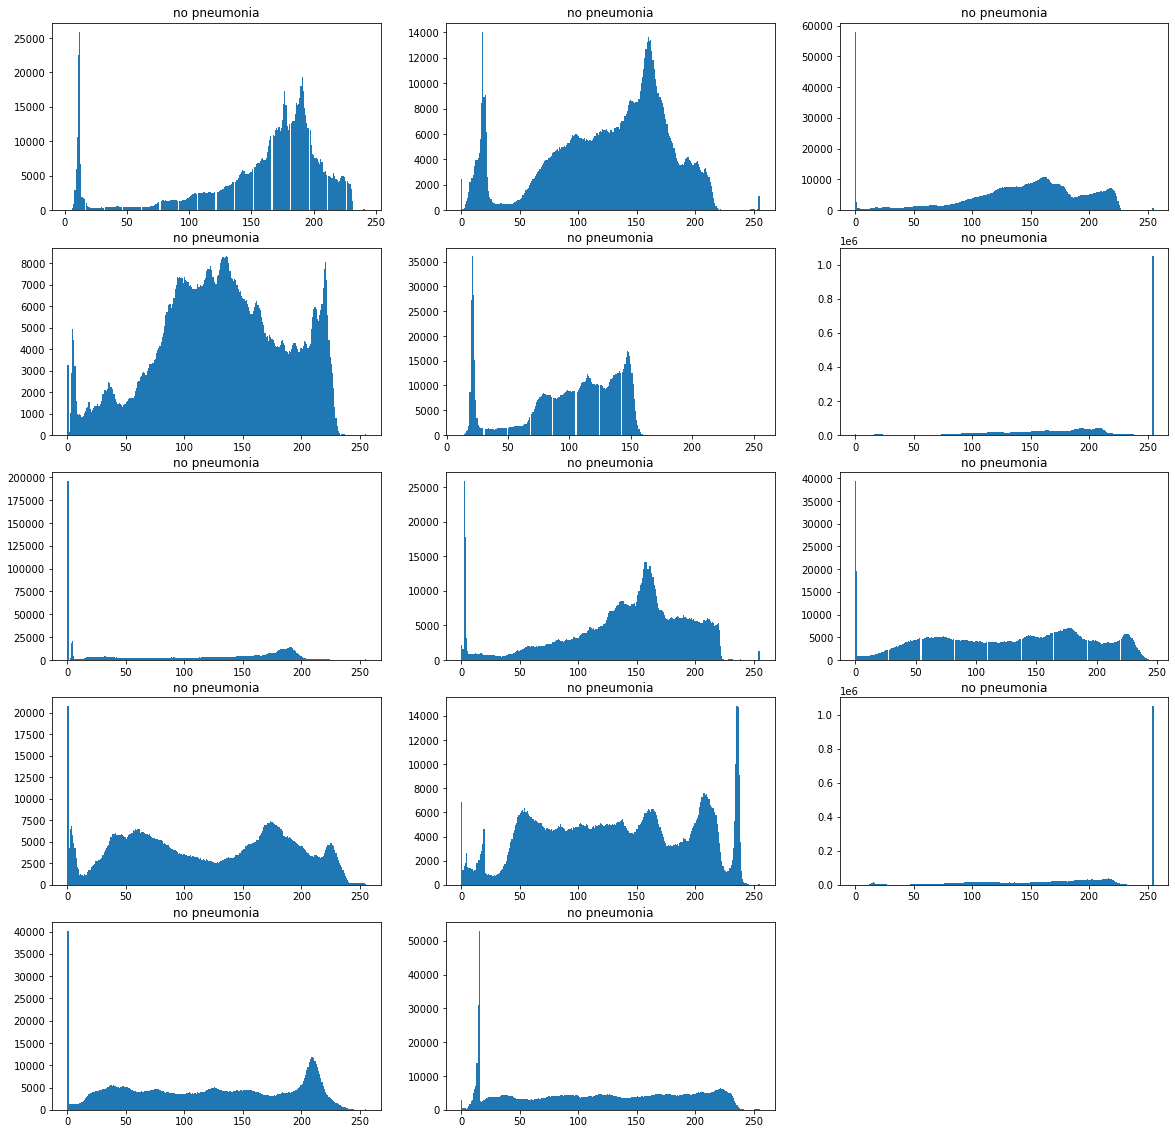

In [25]:
plt.figure(figsize=(20, 20))
columns = 3
for i in range(len(no_finding_df)):
    plt.subplot(len(no_finding_df) / columns + 1, columns, i + 1).set_title('no pneumonia')
    var = plt.imread(no_finding_df[i][1])
    plt.hist(var.ravel()*255, bins=256)

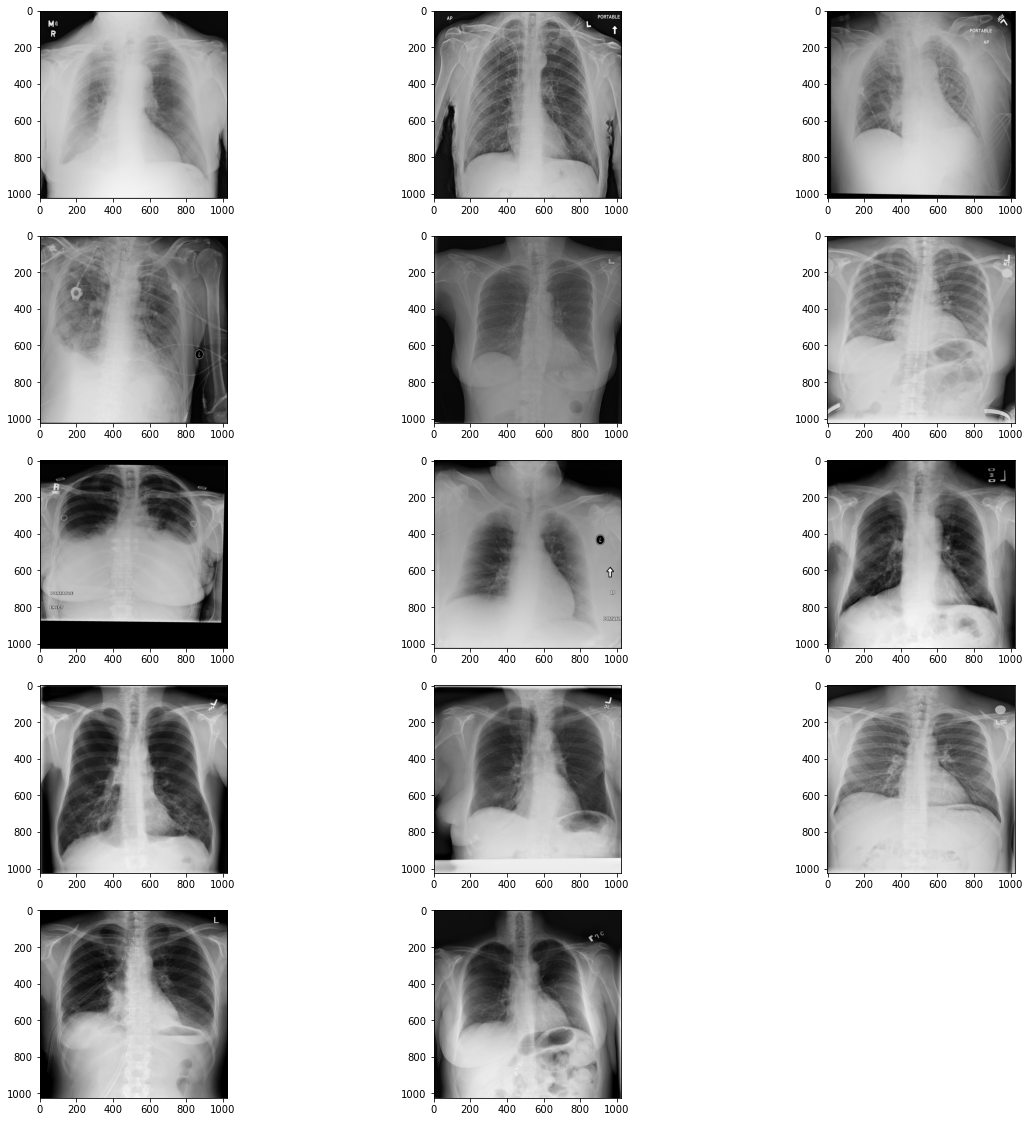

In [22]:
images = []
for i in range(len(no_finding_df)):
    images.append(no_finding_df[i][1])

plt.figure(figsize=(20, 20))
for i, img_path in enumerate(images):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(5, 3, i + 1)
    sp.axis()

    img = mpimg.imread(img_path)
    plt.imshow(img, cmap='gray')

plt.show()

In [23]:
# # Read sample image
# sample_image = plt.imread('/data/images_010/images/00022539_000.png')
# # Plot the sample image
# plt.imshow(sample_image, cmap='gray')